#  import kit

In [54]:
import numpy as np
import importlib
import PEC_Readout_Module as pecro
import PEC_TQG_Module_V2 as peccx
import PEC as pec
import Restore_Retrieve as RR
from  math import sqrt


import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import EstimatorV2
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
importlib.reload(pecro)
importlib.reload(peccx)
importlib.reload(pec)
importlib.reload(RR)

<module 'Restore_Retrieve' from '/home/xiaonan/PEC/Restore_Retrieve.py'>

In [3]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
name = "torino"
device_name = "ibm_" + name
QiskitRuntimeService.save_account(
        channel="ibm_quantum_platform",
        token=token,
        instance=instance,
        set_as_default=True,
        overwrite=True
    )
service = QiskitRuntimeService()
device = service.backend(device_name)
noise_model = NoiseModel.from_backend(device)

In [45]:
backend = AerSimulator.from_backend(device)
backend_options = {
    # "method": "automatic",
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates,
    "coupling_map": device.configuration().coupling_map,
    # parallelism knobs
    # "max_parallel_threads": 0,
    # "max_parallel_experiments":32
    # "device": "GPU",  # if you have qiskit-aer-gpu
}
run_options = {
    "shots": 1024,
    # "seed_simulator": 12345,
}

estimator = EstimatorV2(
    options={
        "backend_options": backend_options,
        "run_options": run_options,
        # "default_precision": 0.0,  # if you want deterministic path where applicable
    }
)
estimator.mode=backend
backendqubitNum = backend.num_qubits
print(backendqubitNum)

133


# Build Circuit

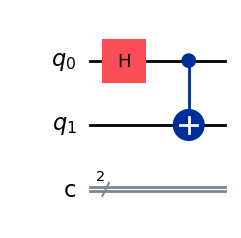

In [51]:
Bell_circuit = QuantumCircuit(2, 2)
Bell_circuit.h(0)
Bell_circuit.cx(0, 1)
Bell_circuit.draw('mpl')

# Calculate Readout PEC Observable

In [21]:
IdealMeasurement = pecro.readout_pec_from_circuit(Bell_circuit, estimator, shots=1024, transpile_backend=backend, batch_size=16)   # -> dict with B, Readout weight, IdealMeasurement, etc.

In [22]:
B  = IdealMeasurement["B"]
readout_weight = IdealMeasurement["ReadoutWeight"]
print("B = \n", B, "\nReadout Weight = \n", readout_weight)

B = 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.11022302e-16 -1.11022302e-16  0.00000000e+00
   0.00000000e+00 -1.11022302e-16 -1.11022302e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99378050e-01  4.43813009e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.21906504e-16  9.99378050e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.45086092e-04 -2.16959551e-04 -2.16959551e-04  9.99654914e-01
   0.00000000e+00 -8.32667268e-17 -8.32667268e-17 -1.11022302e-16
   0.00000000e+00 -8.32667268e-17 -8.32667268e-17 -1.11022302e-16
 

# Calculate CNOT PEC Weight

In [23]:
grammatrix = peccx.compute_tqg_matrices(estimator, Bell_circuit, obs_batch=64)

(c0,t1) 1/16
(c0,t1) 2/16
(c0,t1) 3/16
(c0,t1) 4/16
(c0,t1) 5/16
(c0,t1) 6/16
(c0,t1) 7/16
(c0,t1) 8/16
(c0,t1) 9/16
(c0,t1) 10/16
(c0,t1) 11/16
(c0,t1) 12/16
(c0,t1) 13/16
(c0,t1) 14/16
(c0,t1) 15/16
(c0,t1) 16/16


In [24]:
manifest = RR.save_matrix(grammatrix, fname="grammatrix", parent_dir="TQGGramMatrix")

In [25]:
# grammatrix = RR.load_matrix("TQGGramMatrix/20250902-174159/grammatrix.npy")  
print("num_qubits:", grammatrix["num_qubits"])
print("D x D:", len(grammatrix["row_labels"]), "x", len(grammatrix["col_labels"]))
print("matrices keys:", list(grammatrix["matrices"].keys()))

num_qubits: 2
D x D: 16 x 16
matrices keys: [(0, 1)]


In [26]:
# avgPT = peccx.transform_tqg_matrices_cxm_Ainv(result, cxm_sparse=True, ainv_sparse=False)
avgPT1 = peccx.averaged_pauli_twirling_matrix(grammatrix, B, cxm_sparse=True, ainv_sparse=False)
for k, Mprime in avgPT1["matrices"].items():
    print("CNOT", k, "->", Mprime.shape)
avgPT1

CNOT (0, 1) -> (16, 16)


{'num_qubits': 2,
 'row_labels': ['II',
  'IX',
  'IY',
  'IZ',
  'XI',
  'XX',
  'XY',
  'XZ',
  'YI',
  'YX',
  'YY',
  'YZ',
  'ZI',
  'ZX',
  'ZY',
  'ZZ'],
 'col_labels': ['00',
  '01',
  '0+',
  '0R',
  '10',
  '11',
  '1+',
  '1R',
  '+0',
  '+1',
  '++',
  '+R',
  'R0',
  'R1',
  'R+',
  'RR'],
 'matrices': {(0,
   1): array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  1.11090322e-16,  3.83423411e-20,
           3.83423411e-20, -1.11071152e-16,  1.11159889e-16,
          -3.83423411e-20, -3.83423411e-20,  1.11071152e-16,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  1.00031122e+00, -2.05109923e-19,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           2.36180164e-19,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  2.36180164e-19,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00, -4.43904195e-16,
           0.00000000e+00],
       

In [27]:
weights = peccx.compute_inv_weights_for_package(avgPT1)
manifest = RR.save_vectors(weights, fname="weight", parent_dir="TQGWeight")
weights

{(0,
  1): array([ 7.49901839e-01,  2.49811239e-01, -1.12859848e-04,  3.52147916e-05,
        -1.90485847e-04,  9.25106970e-05,  2.49881558e-01, -2.49881573e-01,
        -1.73438226e-04,  7.54630757e-05, -2.49881494e-01,  2.49881479e-01,
         2.50208956e-01, -2.49881644e-01,  4.25804614e-05,  1.90655101e-04])}

In [ ]:
importlib.reload(peccx)
importlib.reload(RR)

In [ ]:
loadweights = RR.load_vectors("TQGWeight/20250908-135302/weight.npy")
loadweights

In [ ]:
# observables
observables = pecro.build_measurement_pauli(2, 2, order="RL")

# 4) 跑整包（可續跑、顯示進度）
results = pec.run_tqg_pec_package(
    estimator=estimator,
    qcircuit=Bell_circuit,
    observables=observables,
    weights_map=weights,
    combo_batch_size=256,        # 建議 main code 把 batch 調大，減少呼叫次數
    ckpt_path="Bell_pec_run_v1.jsonl",
    resume=True,
    t_backend=backend,               # transpile 用同一個 backend，雜訊/耦合一致
    t_opt_level=0,               # 2 或 3 會比 0 更快（layout & 合併 gate）
    verbose=True
)

# results 是扁平 dict：key= "Bz|tX|cY|iZ|obs"
# 每行也都在 tqg_pec_run.jsonl 裡，隨時能中斷再續跑


In [ ]:
def results_dict_to_col_vector_by_order(results: dict, value_key: str = "value") -> np.ndarray:
    """
    將 results（例如 {'measXX': {'value': ...}, ...}）依字典順序抽出 value，
    回傳形狀 (n, 1) 的 column vector。
    ※ Python 3.7+ dict 會保留插入順序。
    """
    vals = []
    for k, rec in results.items():
        if not isinstance(rec, dict) or value_key not in rec:
            raise KeyError(f"results['{k}'] 缺少 {value_key}")
        vals.append(float(rec[value_key]))
    return np.asarray(vals, dtype=float).reshape(-1, 1)

def readout_weight_to_row_vector(weights: dict, target_key: str) -> np.ndarray:
    """
    取出 weights[target_key]，攤平成 (1, n) 的 row vector。
    """
    if target_key not in weights:
        raise KeyError(f"weights 缺少鍵 '{target_key}'")
    w = np.asarray(weights[target_key], dtype=float).ravel()
    return w.reshape(1, -1)

def row_dot_col(w_row: np.ndarray, e_col: np.ndarray) -> float:
    """
    計算 row × col -> 標量。會檢查維度是否相容。
    """
    w = np.asarray(w_row, dtype=float).reshape(1, -1)
    e = np.asarray(e_col, dtype=float).reshape(-1, 1)
    if w.shape[1] != e.shape[0]:
        raise ValueError(f"shape 不相符：{w.shape} x {e.shape}")
    return float(w @ e)

In [ ]:
# e = results 的 column vector（依字典順序）
e = results_dict_to_col_vector_by_order(results)

# 拿 ZZ / IX 的 row vector
w_ZZ = readout_weight_to_row_vector(readout_weight, "ZZ")
w_IX = readout_weight_to_row_vector(readout_weight, "IX")

# 線性組合的預估值
val_ZZ = row_dot_col(w_ZZ, e)
val_IX = row_dot_col(w_IX, e)
print("recon ZZ =", val_ZZ)
print("recon IX =", val_IX)

In [ ]:
CirTran = q.compiler.transpile(Bell_circuit, backend=backend, optimization_level=0)
CirTran = pec._compact_qubits(CirTran)
pubs = [(CirTran, [obs], None) for obs in observables.values()]
res_noisy = estimator.run(pubs).result()
evs = pec._extract_evs_from_result(res_noisy)

In [ ]:
print(results)
print(evs)

In [16]:
ORDER = ["II","IX","IY","IZ","XI","XX","XY","XZ","YI","YX","YY","YZ","ZI","ZX","ZY","ZZ"]

def meas_dict_to_vec(meas_dict, order=ORDER, prefix="meas"):
    """把 {'measXX': {'value': ...}, ...} 轉成向量 m（長度16）"""
    return np.array([meas_dict[f"{prefix}{lbl}"]["value"] for lbl in order], dtype=float)

def expect_from_weights(weights_dict, label, m):
    """用對應權重重建理想期望值 ⟨label⟩"""
    w = np.asarray(weights_dict[label]).reshape(-1)
    return float(w @ m)

def chsh_from_pec(meas_dict, weights_dict):
    m = meas_dict_to_vec(meas_dict, ORDER)
    ZZ = expect_from_weights(weights_dict, "ZZ", m)
    ZX = expect_from_weights(weights_dict, "ZX", m)
    XZ = expect_from_weights(weights_dict, "XZ", m)
    XX = expect_from_weights(weights_dict, "XX", m)
    E00 = (ZZ + ZX)/sqrt(2)
    E01 = (ZZ - ZX)/sqrt(2)
    E10 = (XZ + XX)/sqrt(2)
    E11 = (XZ - XX)/sqrt(2)
    S = E00 + E01 + E10 - E11
    return dict(PE00=E00, PE01=E01, PE10=E10, PE11=E11, S=S)

def chsh_original(meas_dict):
    ZZ = meas_dict[15]
    ZX = meas_dict[7]
    XZ = meas_dict[13]
    XX = meas_dict[5]
    E00 = float((ZZ + ZX)/sqrt(2))
    E01 = float((ZZ - ZX)/sqrt(2))
    E10 = float((XZ + XX)/sqrt(2))
    E11 = float((XZ - XX)/sqrt(2))
    S = E00 + E01 + E10 - E11
    return dict(E00=E00, E01=E01, E10=E10, E11=E11, S=S)



In [ ]:
Origin_result = chsh_original(evs)
PEC_result = chsh_from_pec(results, readout_weight)
print(Origin_result)
print(PEC_result)

In [13]:
# ====== 0) 依你的既有工具：小工具重用/補齊 ======
# observables
observables = pecro.build_measurement_pauli(2, 2, order="RL")
ORDER = ["II","IX","IY","IZ","XI","XX","XY","XZ","YI","YX","YY","YZ","ZI","ZX","ZY","ZZ"]

def meas_dict_to_vec(meas_dict, order=ORDER, prefix="meas"):
    """把 {'measXX': {'value': ...}, ...} 轉成向量 m（長度16，依 ORDER）"""
    return np.array([float(meas_dict[f"{prefix}{lbl}"]["value"]) for lbl in order], dtype=float)

def expect_from_weights(weights_dict, label, m):
    """用對應權重重建理想期望值 ⟨label⟩"""
    w = np.asarray(weights_dict[label], dtype=float).reshape(-1)
    return float(w @ m)

def chsh_from_meas_vector(m):
    """給定長度16的 measurement 向量（依 ORDER），計 CHSH 四個 E_ij 與 S"""
    # 依 ORDER 的索引：XX=5, ZX=7, XZ=13, ZZ=15
    XX = float(m[5]);  ZX = float(m[7]);  XZ = float(m[13]);  ZZ = float(m[15])
    rt2 = np.sqrt(2.0)
    E00 = (ZZ + ZX)/rt2
    E01 = (ZZ - ZX)/rt2
    E10 = (XZ + XX)/rt2
    E11 = (XZ - XX)/rt2
    S = E00 + E01 + E10 - E11
    return dict(E00=float(E00), E01=float(E01), E10=float(E10), E11=float(E11), S=float(S))

def chsh_from_pec_results(meas_dict, weights_dict):
    """(PEC) 用 weights 把 16 組 noisy measurement 重建出理想 ⟨XX,ZX,XZ,ZZ⟩ 再算 CHSH"""
    m = meas_dict_to_vec(meas_dict, ORDER)
    XX = expect_from_weights(weights_dict, "XX", m)
    ZX = expect_from_weights(weights_dict, "ZX", m)
    XZ = expect_from_weights(weights_dict, "XZ", m)
    ZZ = expect_from_weights(weights_dict, "ZZ", m)
    rt2 = np.sqrt(2.0)
    E00 = (ZZ + ZX)/rt2
    E01 = (ZZ - ZX)/rt2
    E10 = (XZ + XX)/rt2
    E11 = (XZ - XX)/rt2
    S = E00 + E01 + E10 - E11
    return dict(E00=float(E00), E01=float(E01), E10=float(E10), E11=float(E11), S=float(S))

def build_pubs_for_all_observables(qc, observables_dict):
    """把單一 (transpiled) 電路搭配每個 observable 的 pub 列表，供 Estimator.run 使用"""
    return [(qc, [obs], None) for obs in observables_dict.values()]

def estimator_evs_to_vec(evs, order=ORDER, prefix="meas"):
    """
    把 estimator 提取的測量結果統一轉成依 ORDER 的長度16向量。
    支援：
      - np.ndarray / list: 直接視為依 ORDER 排好的長度16向量
      - {'measXX': val} 扁平 dict
      - {'measXX': {'value': ...}} 巢狀 dict
    """
    # case A: array-like
    if isinstance(evs, (list, tuple, np.ndarray)):
        arr = np.asarray(evs, dtype=float).ravel()
        if arr.size != len(order):
            raise ValueError(f"array-like 長度應為 {len(order)}，但拿到 {arr.size}")
        return arr

    # case B: dict-like
    if isinstance(evs, dict):
        # 取一個 sample 看 value 結構
        sample_val = next(iter(evs.values()))
        if isinstance(sample_val, dict) and "value" in sample_val:
            # {'measXX': {'value': ...}}
            return np.array(
                [float(evs[f"{prefix}{lbl}"]["value"]) for lbl in order],
                dtype=float
            )
        else:
            # {'measXX': val}
            return np.array(
                [float(evs[f"{prefix}{lbl}"]) for lbl in order],
                dtype=float
            )

    raise TypeError(f"不支援的 evs 型別：{type(evs)}")

In [14]:
# ====== 1) 只做一次：前置（轉譯電路與 pubs） ======
#   - 你可把 opt level 調為 2 或 3 來加速（不改邏輯，只是 layout/合併）
CirTran = q.compiler.transpile(Bell_circuit, backend=backend, optimization_level=0)
CirTran = pec._compact_qubits(CirTran)
pubs_all = build_pubs_for_all_observables(CirTran, observables)

In [15]:
# ====== 2) 定義：單次執行（PEC 與 無 PEC）回傳 CHSH S ======

def one_trial_pec_S(estimator, qcircuit, observables, weights_map, readout_weights,
                    combo_batch_size=256, ckpt_path=None, seed=None, verbose=False):
    """
    跑一次 PEC：呼叫你的 run_tqg_pec_package，然後用權重重建 CHSH，回傳 S（float）。
    seed 若要影響抽樣，請把它配置在 estimator/run_options（或外部設 estimator 用的 seed）。
    """
    # 給每次唯一 ckpt 檔名（避免互相覆蓋）；若不想留檔，可設為 None。
    if ckpt_path is None:
        ckpt_path = f"_tmp_pec_trial_seed{seed or 0}.jsonl"

    results = pec.run_tqg_pec_package(
        estimator=estimator,
        qcircuit=qcircuit,
        observables=observables,
        weights_map=weights_map,
        combo_batch_size=combo_batch_size,
        ckpt_path=ckpt_path,
        resume=False,                # 多次 trial 通常不續跑；要續跑可以改 True
        t_backend=backend,
        t_opt_level=0,
        verbose=verbose
    )
    cs = chsh_from_pec_results(results, readout_weights)
    return float(cs["S"]), cs  # (S, 明細)

def one_trial_nopec_S(estimator, pubs):
    """
    跑一次「無 PEC」：同一組 pubs（固定電路 + 每個 observable），
    從 estimator 直接得到 noisy 期望值，再依 ORDER 組成向量、算 CHSH，回傳 S（float）。
    """
    res = estimator.run(pubs).result()
    evs = pec._extract_evs_from_result(res)      # {'measXX': val, ...}
    m = estimator_evs_to_vec(evs, order=ORDER)   # 長度16
    cs = chsh_from_meas_vector(m)
    return float(cs["S"]), cs  # (S, 明細)

# ====== 3) 多次重複：主函式 ======

def compare_pec_vs_nopec(
    estimator,
    qcircuit,
    observables,
    weights_map,
    readout_map,
    pubs,
    n_trials=50,
    combo_batch_size=256,
    base_ckpt_prefix="Bell_pec_trial",
    show_progress=True,
    randomize_seed=False
):
    """
    連續做 n_trials 次：
      - 每次做「PEC 版」與「無 PEC」各一次（抽樣噪聲會讓每次結果略有差異）
      - 回傳所有 trial 的 S 值陣列與摘要
    注意：
      - 如果你要讓 seed 生效，請在建立 estimator 時設置 seed（或在每次 trial 重新建 estimator/run_options）。
      - 這裡預設只是運行 estimator.run 與你的 PEC 流程；硬體/噪聲由 backend 控制。
    """
    S_pec = []
    S_nopec = []
    details_pec = []
    details_nopec = []

    for i in range(1, n_trials+1):
        seed = (None if not randomize_seed else np.random.randint(0, 2**31-1))
        # PEC
        s_pec, cs_pec = one_trial_pec_S(
            estimator=estimator,
            qcircuit=qcircuit,
            observables=observables,
            weights_map=weights_map,
            readout_weights=readout_map,
            combo_batch_size=combo_batch_size,
            ckpt_path=f"{base_ckpt_prefix}_{i}.jsonl",
            seed=seed,
            verbose=False
        )
        # NO-PEC
        s_nopec, cs_nopec = one_trial_nopec_S(estimator, pubs)

        S_pec.append(float(s_pec))
        S_nopec.append(float(s_nopec))
        details_pec.append(cs_pec)
        details_nopec.append(cs_nopec)

        # if show_progress and (i % max(1, n_trials//5) == 0 or i == 1 or i == n_trials):
        print(f"[{i}/{n_trials}]  S(PEC)={s_pec:.8f}   S(noPEC)={s_nopec:.8f}")

    S_pec = np.asarray(S_pec, dtype=float)
    S_nopec = np.asarray(S_nopec, dtype=float)

    summary = {
        "PEC_mean": float(S_pec.mean()),
        "PEC_std": float(S_pec.std(ddof=1)) if len(S_pec) > 1 else 0.0,
        "noPEC_mean": float(S_nopec.mean()),
        "noPEC_std": float(S_nopec.std(ddof=1)) if len(S_nopec) > 1 else 0.0,
    }
    return S_pec, S_nopec, summary, details_pec, details_nopec


In [28]:
# ====== 4) 跑起來（把 n_trials 調到你想要的數量） ======

n_trials = 5
S_pec, S_nopec, summary, details_pec, details_nopec = compare_pec_vs_nopec(
    estimator=estimator,
    qcircuit=Bell_circuit,
    observables=observables,
    weights_map=weights,
    readout_map=readout_weight,
    pubs=pubs_all,
    n_trials=n_trials,
    combo_batch_size=1024,
    base_ckpt_prefix="Bell_pec_run_trial_V3",
    show_progress=True,
    randomize_seed=True
)

print("=== Summary over trials ===")
print(summary)


--- Batch 1 (Size: 16) ---
[TIMER] Circuit Generation: 0.0016s
[TIMER] Transpilation:       1.4924s
[TIMER] Estimator Execution:  43.6736s
[TIMER] Result Processing:    0.0001s
[TIMER] Total Batch Time:     45.1695s
---------------------------------

--- Batch 1 (Size: 16) ---
[TIMER] Circuit Generation: 0.0016s
[TIMER] Transpilation:       1.3917s
[TIMER] Estimator Execution:  45.5836s
[TIMER] Result Processing:    0.0001s
[TIMER] Total Batch Time:     46.9790s
---------------------------------

--- Batch 1 (Size: 16) ---
[TIMER] Circuit Generation: 0.0019s
[TIMER] Transpilation:       1.1736s
[TIMER] Estimator Execution:  41.8215s
[TIMER] Result Processing:    0.0001s
[TIMER] Total Batch Time:     42.9987s
---------------------------------

--- Batch 1 (Size: 16) ---
[TIMER] Circuit Generation: 0.0018s
[TIMER] Transpilation:       2.1165s
[TIMER] Estimator Execution:  42.6819s
[TIMER] Result Processing:    0.0001s
[TIMER] Total Batch Time:     44.8018s
------------------------------

In [29]:
details_nopec

[{'E00': 0.703540674225979,
  'E01': 0.7035406511179034,
  'E10': 0.7031812784684698,
  'E11': -0.7031807853157792,
  'S': 2.8134433891281314},
 {'E00': 0.703540674225979,
  'E01': 0.7035406511179034,
  'E10': 0.7031812784684698,
  'E11': -0.7031807853157792,
  'S': 2.8134433891281314},
 {'E00': 0.703540674225979,
  'E01': 0.7035406511179034,
  'E10': 0.7031812784684698,
  'E11': -0.7031807853157792,
  'S': 2.8134433891281314},
 {'E00': 0.703540674225979,
  'E01': 0.7035406511179034,
  'E10': 0.7031812784684698,
  'E11': -0.7031807853157792,
  'S': 2.8134433891281314},
 {'E00': 0.703540674225979,
  'E01': 0.7035406511179034,
  'E10': 0.7031812784684698,
  'E11': -0.7031807853157792,
  'S': 2.8134433891281314}]

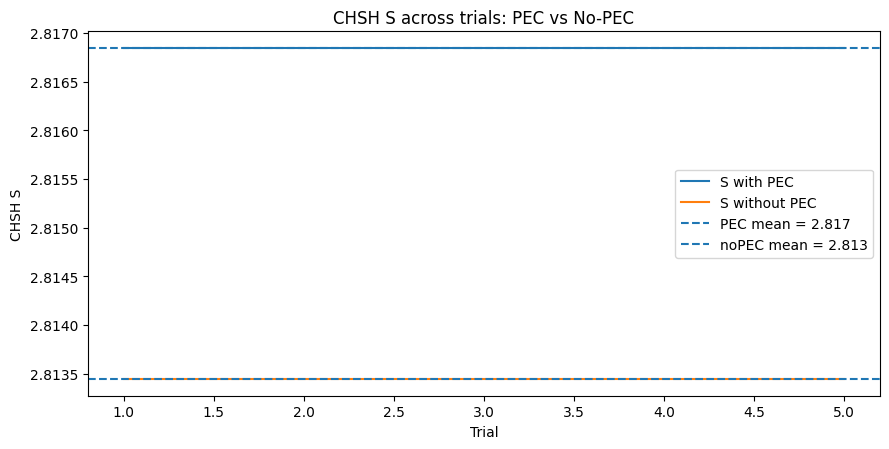

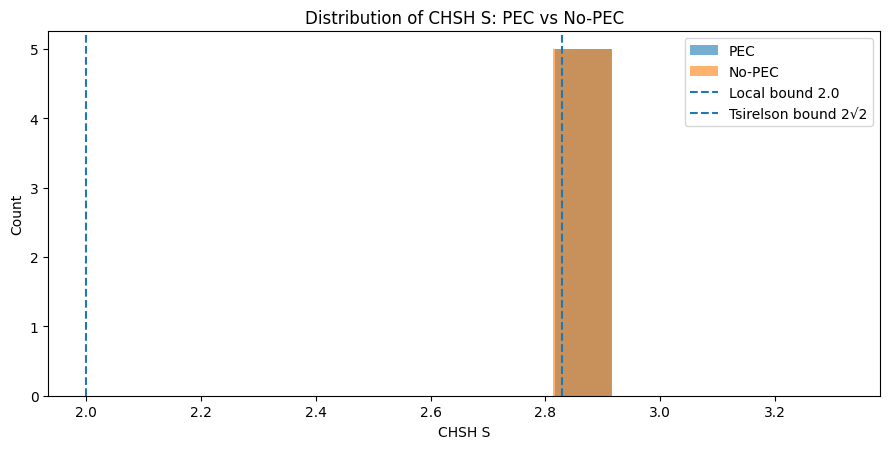

In [30]:
# ====== 5) 畫圖：折線 + 兩條平均線；以及分布（直方圖） ======
import matplotlib.pyplot as plt

# 折線圖（每次 trial 的 S 值）
plt.figure(figsize=(9,4.6))
plt.plot(range(1, n_trials+1), S_pec, label="S with PEC")
plt.plot(range(1, n_trials+1), S_nopec, label="S without PEC")
plt.axhline(summary["PEC_mean"], linestyle="--", label=f"PEC mean = {summary['PEC_mean']:.3f}")
plt.axhline(summary["noPEC_mean"], linestyle="--", label=f"noPEC mean = {summary['noPEC_mean']:.3f}")
plt.xlabel("Trial")
plt.ylabel("CHSH S")
plt.title("CHSH S across trials: PEC vs No-PEC")
plt.legend()
plt.tight_layout()
plt.show()

# 直方圖（分布比較）
plt.figure(figsize=(9,4.6))
plt.hist(S_pec, bins=max(10, n_trials//5), alpha=0.6, label="PEC")
plt.hist(S_nopec, bins=max(10, n_trials//5), alpha=0.6, label="No-PEC")
plt.axvline(2.0, linestyle="--", label="Local bound 2.0")
plt.axvline(2*np.sqrt(2), linestyle="--", label="Tsirelson bound 2√2")
plt.xlabel("CHSH S")
plt.ylabel("Count")
plt.title("Distribution of CHSH S: PEC vs No-PEC")
plt.legend()
plt.tight_layout()
plt.show()